In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [0]:
data = pd.read_csv("https://storage.googleapis.com/dsa_project/AB_NYC_2019.csv", parse_dates=[12])

# Data exploratory

In [0]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null datetime64[ns]
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-nu

In [0]:
#### Shape of the data ####
print("Number of features : {}".format(data.shape[1]))
print("Number of observations : {}".format(data.shape[0]))

Number of features : 16
Number of observations : 48895


# Data cleaning

In [0]:
### Check for missing values in the data set #####
print('Null values in Airbnb dataset: \n')
print(data.isnull().sum())

Null values in Airbnb dataset: 

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


#### As the number of missing values in the "name" and "host_name" columns are very small (16 and 21 respectively) compared to the total size of the observations, it was decided to ignore these observations.

In [0]:
#### Dropping missing values rows for "name" and "host_name" ######
data.dropna(subset = ['name'], inplace=True)
data.dropna(subset = ['host_name'], inplace=True)

In [0]:
### Fill NaN value in the column `reviews_per_month` by 0
data.fillna({'reviews_per_month':0}, inplace=True)
### Remove cells where price = 0
data = data[data['price']>0]

### Availability of a post must be greater than 0
data = data[data['availability_365'] > 0]



# Data Augmentation

In [0]:
# Get the number of days since a room was reviewed and Replace NaT value by -1
zero_time_revies = '2019-07-08' # Last day in the dataset will be our t0
data['days_since_last_review'] = (pd.to_datetime(zero_time_revies) - pd.to_datetime(data['last_review'])).apply(lambda i: -1 if pd.isnull(i) else int(i.days))

-------------------------------
#### Add new columns 'distance_jfk' and 'distance_central_park'
#### To get the longitude and latitude of JFK airport and Central Park, we used this [web site](https://www.coordinatesfinder.com).

In [0]:
from geopy.distance import geodesic
data['distance_jfk'] = data.apply(lambda x: geodesic((40.6413111, -73.7781391), (x['latitude'], x['longitude'])).meters, axis=1)
data['distance_central_park'] = data.apply(lambda x: geodesic((40.7828647, -73.9653551), (x['latitude'], x['longitude'])).meters, axis=1)

#### Check whether column 'name' contains specific words that can be linked to a luxury posting for example.

In [0]:
LUXURY_WORDS = ['pool','spa','loft', 'studio', 'wall','street','townhouse', 'views', 'midtown', 'luxury', 'central', 'park', 'soho', 'village', 'suite', 'west', 'new']
HOT_WORDS = ['pets','smoke','iron', 'internet', 'wifi', 'laptop', 'wi-fi', 'family', 'kid', 'private', 'air']

In [0]:
# Function that checks if a word is in a list of words.
def is_in(title, words):
    for w in words:
        if w.lower() in title.lower():
            return 1 # True
    return 0 # False

#### Convert 'name' to string
data.name=data.name.astype(str)
#### Add the new columns
data['is_luxury'] = data.apply(lambda r: is_in(r['name'], LUXURY_WORDS), axis=1)
data['has_extra_services'] = data.apply(lambda r: is_in(r['name'], HOT_WORDS), axis=1)

In [0]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,distance_jfk,distance_central_park,is_luxury,has_extra_services
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,262,16443.482611,15044.825452,1,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,48,21391.471072,3600.585619,1,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,1,365,-1,23200.378569,3514.924582,1,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3,16110.969765,10862.494816,0,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,16,20404.901124,3992.287148,1,0


# Explanatory Analysis

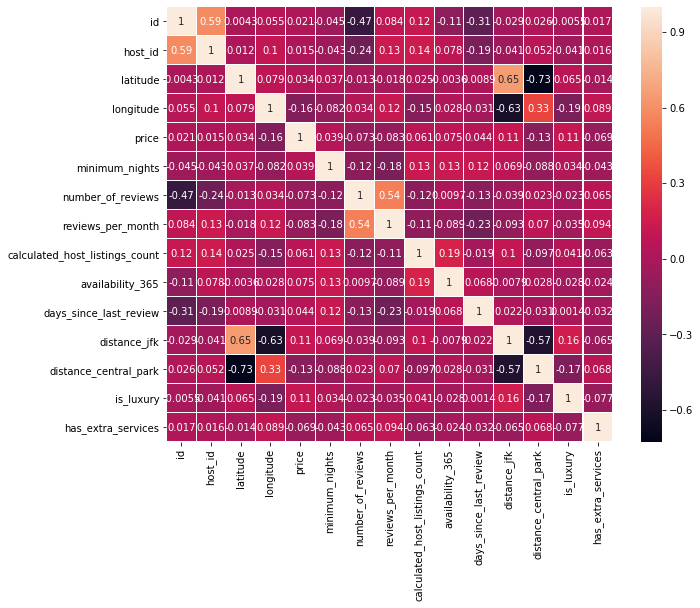

In [0]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, linewidths=0.1)
plt.show()

Text(0, 0.5, 'Count')

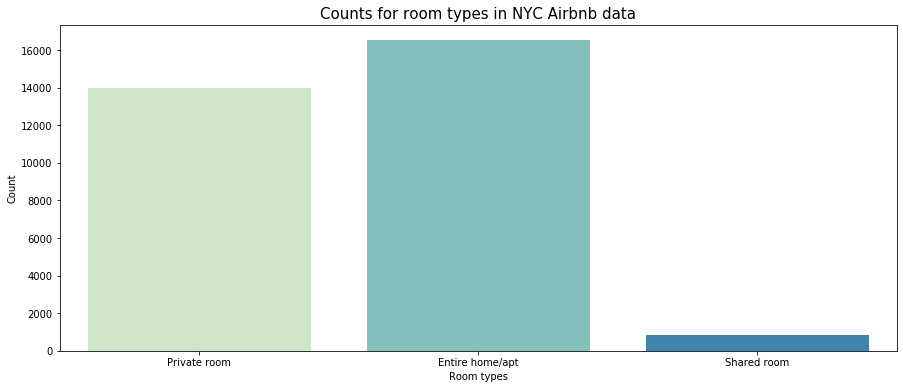

In [0]:
# Room types count
plt.figure(figsize=(15,6))
sns.countplot(data=data, x='room_type', palette='GnBu')
plt.title('Counts for room types in NYC Airbnb data', fontsize=15)
plt.xlabel('Room types')
plt.ylabel("Count")

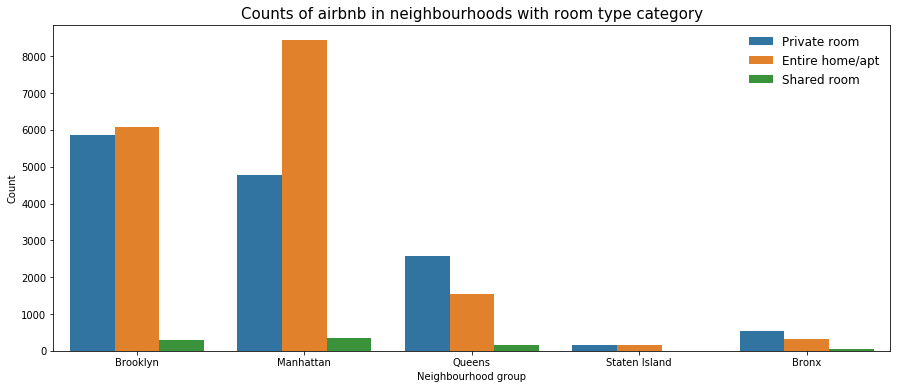

In [0]:
# Neighbourhood groups with counts with category room_type

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='neighbourhood_group', hue='room_type')
plt.title('Counts of airbnb in neighbourhoods with room type category', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

#### It can be seen from the graph above that in Manhathan, clients prefer to rent the entire apartment while in other neighbourhoods, clients prefer the private room.

Text(0, 0.5, 'Frequency')

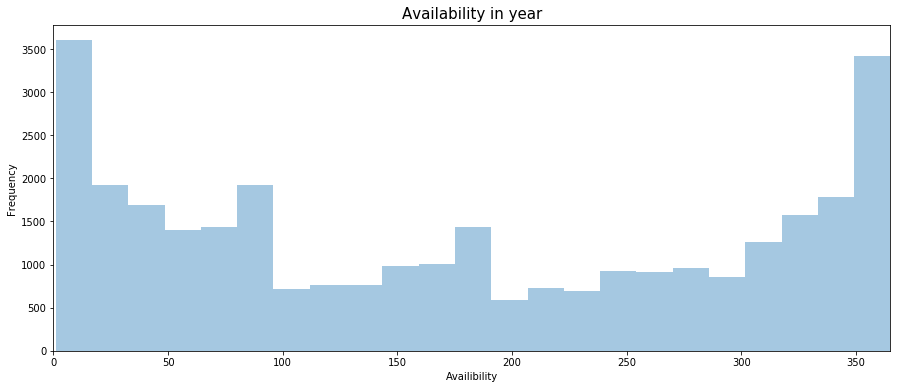

In [0]:
# Availability in year of AirBnB appartments
plt.figure(figsize=(15,6))
sns.distplot(data.availability_365, kde=False)
plt.xlim(0,365)
plt.title('Availability in year', fontsize=15)
plt.xlabel('Availibility')
plt.ylabel("Frequency")

#### As the graphic above shows, the highest avaibility in term of days per year for AirBnB is between [0;30].

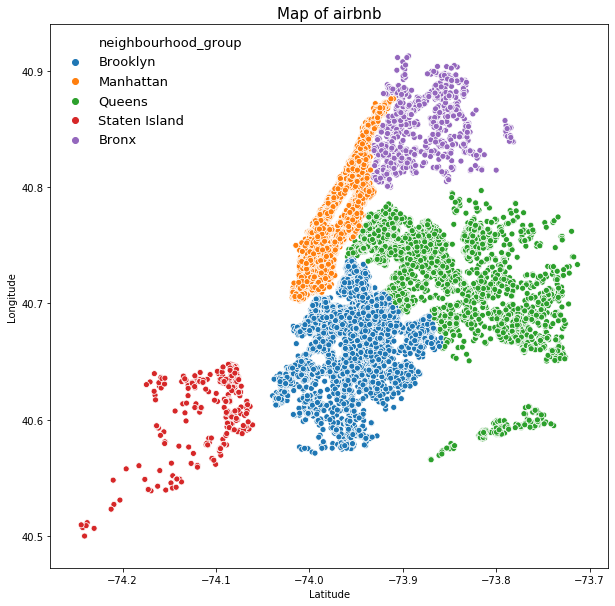

In [0]:
# Location of AirBnB host in New York City - map of hosts
plt.figure(figsize=(10,10))
a = sns.scatterplot(data=data, x='longitude', y='latitude', hue='neighbourhood_group')
plt.title('Map of airbnb', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.legend(frameon=False, fontsize=13)

Text(0, 0.5, 'Price')

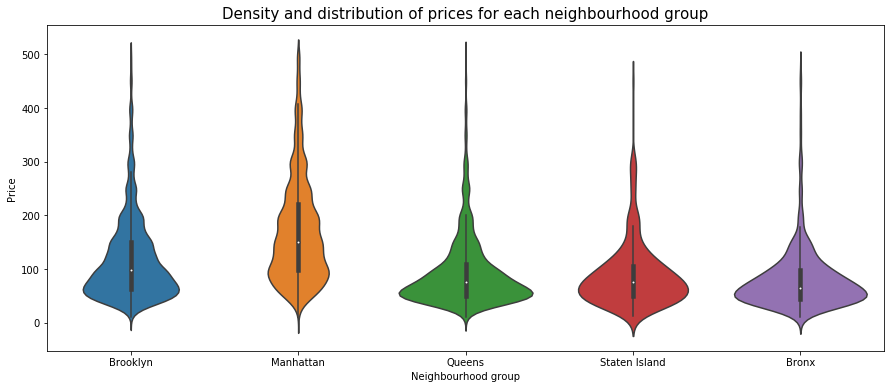

In [0]:
# distribution of prices

plt.figure(figsize=(15,6))
sns.violinplot(data=data[data.price <500], x='neighbourhood_group', y='price')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

# ML models



## 1.   Goals of the ML models:
### The goal in this project is `predicting the popularity of an airbnb post`. The popularity of a posting could be useful to `hostq` and `businessmen` as they will be able to optimize their postings to maximize bookings or to predict the income a particular posting is going to generate in the future.
## 2.   Assumption:
### We refer to the popularity of an airbnb post as its quantity of rent (number of times it's rented) which is assumed as the feature `number of reviews` in the data set.
## 3.  Limit of the assumption:
### Our assumption has a limit because we are assuming that all the guests leave a review when they rent an airbnb which is not true all the time.






# Strategy 1 : Predict `Popularity of an airbnb post`(`number of reviews`) using Light GBM
--- --- ---
In the following part, we applied a newly machine learning algorithm called <span style= "color:blue"> `Light GBM` </span>  which is a gradient boosting framework that uses tree based learning algorithm. It grows tree vertically while other algorithm grows trees horizontally what makes it faster than other algorithms. \\
As suggested in this [article](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), `Light GBM` is very sensitive to `Overfitting` thus in our case, the data set has more than 10.0000 rows.


In [0]:
features =['host_id','neighbourhood','neighbourhood_group','days_since_last_review', 'distance_jfk', 'has_extra_services','distance_central_park','is_luxury', 'has_extra_services','has_extra_services', 'longitude', 'room_type','minimum_nights', 'reviews_per_month','calculated_host_listings_count','availability_365','price']
X = data[features]
y = data['number_of_reviews']

In [0]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
X[['neighbourhood','neighbourhood_group', 'room_type']] = X[['neighbourhood','neighbourhood_group', 'room_type']].apply(LabelEncoder().fit_transform)

In [0]:
# Split data into train test data
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=2019)

In [0]:
# Training the classifier
import lightgbm as lgb
from sklearn import metrics

categorical_features = ['host_id','neighbourhood','neighbourhood_group','is_luxury','has_extra_services', 'room_type']
####################### Training step ############################################################
train = lgb.Dataset(data = X_train,label = y_train, categorical_feature = categorical_features)

####################### Validation step ###########################################################
test = lgb.Dataset(data = X_test, label=y_test, categorical_feature=categorical_features)

param = {'num_leaves':45, 'num_trees':10000000, 'objective':'regression'}
param['metric'] = 'rmse'
param['num_threads'] = 3
param['early_stopping_round'] = 50 # Will reduce excessive iterations, it will stop as soon as there is no relative increase in validation


bst = lgb.train(param, train, valid_sets = [train, test])

[1]	training's rmse: 49.3726	valid_1's rmse: 49.755
Training until validation scores don't improve for 50 rounds.
[2]	training's rmse: 47.4953	valid_1's rmse: 48.0546
[3]	training's rmse: 45.8722	valid_1's rmse: 46.6599
[4]	training's rmse: 44.4667	valid_1's rmse: 45.4514
[5]	training's rmse: 43.269	valid_1's rmse: 44.5066
[6]	training's rmse: 42.2044	valid_1's rmse: 43.6668
[7]	training's rmse: 41.3093	valid_1's rmse: 42.9533
[8]	training's rmse: 40.5414	valid_1's rmse: 42.3407
[9]	training's rmse: 39.8583	valid_1's rmse: 41.8336
[10]	training's rmse: 39.2388	valid_1's rmse: 41.3744
[11]	training's rmse: 38.7109	valid_1's rmse: 41.015
[12]	training's rmse: 38.2151	valid_1's rmse: 40.7141
[13]	training's rmse: 37.7809	valid_1's rmse: 40.4574
[14]	training's rmse: 37.3872	valid_1's rmse: 40.2299
[15]	training's rmse: 37.0086	valid_1's rmse: 40.0071
[16]	training's rmse: 36.7028	valid_1's rmse: 39.8834
[17]	training's rmse: 36.4141	valid_1's rmse: 39.7682
[18]	training's rmse: 36.1131	va

In [0]:
print("The range of values for number of reviews in df_brooklyn is:[{},{}] ".format(data['number_of_reviews'].min(),data['number_of_reviews'].max()))


The range of values for number of reviews in df_brooklyn is:[0,629] 


## Result interepretation : 
-----
In the model above, as the `test's rmse` is close to the`training's rmse` thus our model is not overfitting. And compared to the range for `number_of_reviews` (dependent variable of the model), our `rmse` value is small which confirms the goodness of our model.

# Strategy 2 : Predict `number of reviews` using a tree boosting based model `XGboost`.

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##### Define Model
param = {
    "objective": "reg:squarederror",
    "nthread":4,
    'n_estimators': 2000,
}

xgb_model = xgb.XGBRegressor(**param)

############## Performance of the model ##################
RMSE: 32.5124708301383
MAE: 17.663111174140194
R2: 0.6048547393372259


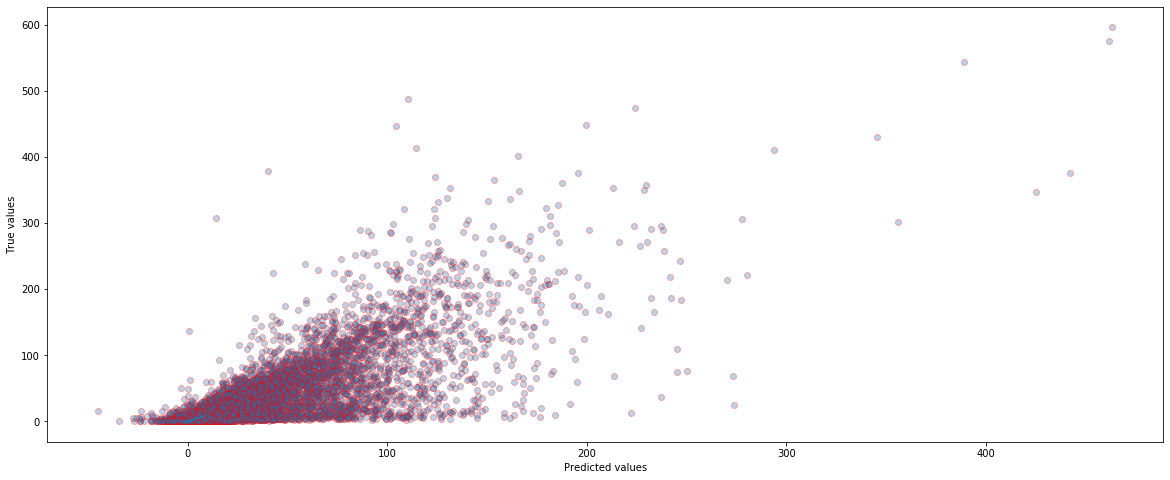

In [0]:
#### Remove duplicated columns in the train and test if there are some : this is to prevent Xgboost error : "features must be unique"
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]
#### Training model and make prediction with the trained model
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("############## Performance of the model ##################")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

fig, ax= plt.subplots(1, figsize=(20,8))
ax.scatter(y_pred, y_test.values, alpha=0.3, marker='o', edgecolors='red')
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values')
ax.plot(list(range(-1,10)), list(range(-1,10)))


ResidualsPlot(alpha=0.75,
              ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f52b07a8e48>,
              hist=True, line_color=None, model=None, test_color=None,
              train_color=None)

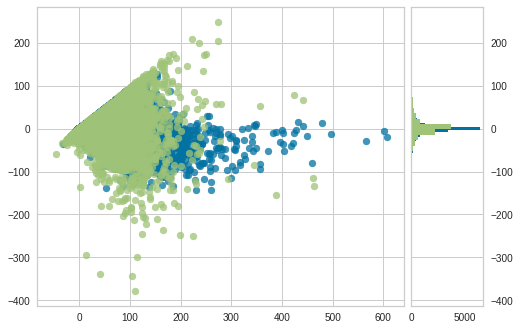

In [0]:
########### Residual Plots #######################
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(xgb_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer                # Finalize and render the figure

#### What are the most important features to the model?

In [0]:
### Install non standard packages in colab notebook
!pip install eli5
import eli5
eli5.explain_weights(xgb_model)

     |████████████████████████████████| 112kB 2.8MB/s 


Using TensorFlow backend.


Weight,Feature
0.2610,reviews_per_month
0.1842,host_id
0.1184,availability_365
0.0827,room_type
0.0567,days_since_last_review
0.0528,calculated_host_listings_count
0.0350,neighbourhood_group
0.0333,has_extra_services
0.0295,minimum_nights
0.0283,neighbourhood


#### The top 4 most important features in our model for predicting the response variable are :
 

*   reviews_per_month
*   host_id
*   number of days the post is available during the year
*   number of days since last the review left for the posting




# Strategy 3 : Predict `number of reviews` using a Linear Regression model.

In [0]:
from sklearn.linear_model import LinearRegression

#### Define and train the classifier
regClf = LinearRegression().fit(X_train, y_train)

#### Predict with the trained classifier
y_pred_reg = regClf.predict(X_test)
print("############## Performance of the model ##################")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test.values, y_pred_reg))}")
print(f"MAE: {mean_absolute_error(y_test.values, y_pred_reg)}")
print(f"R2: {r2_score(y_test.values, y_pred_reg)}")


############## Performance of the model ##################
RMSE: 40.02490231423569
MAE: 25.50792669866492
R2: 0.40115091877308784


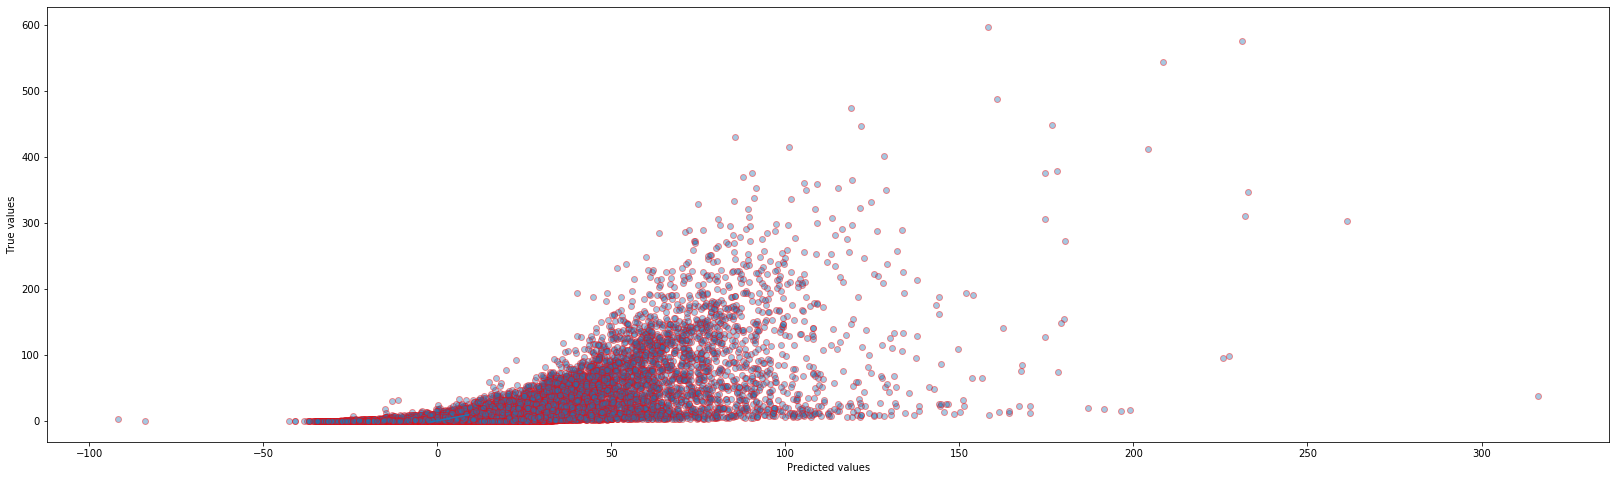

In [0]:
fig, ax= plt.subplots(1, figsize=(28,8))
ax.scatter(y_pred_reg, y_test.values, alpha=0.4, marker='o', edgecolors= 'red')
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values')
ax.plot(list(range(-2,10)), list(range(-2,10)))


<Figure size 1440x576 with 0 Axes>

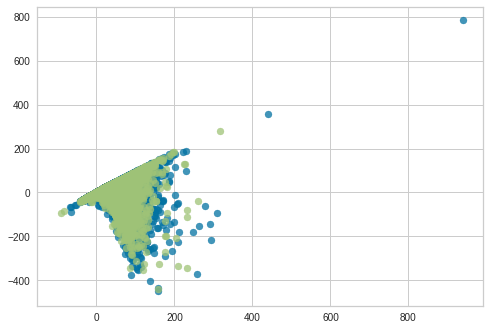

<Figure size 1440x576 with 0 Axes>

In [0]:
########### Residual Plots #######################
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(regClf, hist=False)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer                # Finalize and render the figure
plt.figure(figsize=(20,8))

#### What are the most important predictors in Linear Regression model?

In [0]:
eli5.explain_weights(regClf, feature_names= X_train.columns.tolist())


Weight?,Feature
+16.370,reviews_per_month
+1.939,has_extra_services
+0.040,availability_365
-0.000,host_id
-0.000,distance_jfk
-0.000,distance_central_park
-0.002,neighbourhood
-0.005,price
-0.014,days_since_last_review
-0.033,calculated_host_listings_count


### Result Interpretation:
The most impactful features in predicting the popularity for the linear regression model are not the same for the previous models. From the performance of the linear regression model, we can conclude that it's the less performant because it has the highest `RMSE`value and the smaller `R2` coeffiscient value.